In [6]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 1. Datenvorbereitung

In [7]:
def load_and_clean_data(file_path):
    print(f"Lade Daten aus {file_path}...")
    df = pd.read_csv(file_path)
    df['Content'] = df['Content'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', str(x)))  # Sonderzeichen entfernen
    df['Content'] = df['Content'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())  # Mehrfaches Leerzeichen entfernen
    df['WordCount'] = df['Content'].apply(lambda x: len(x.split()))  # Wortanzahl berechnen
    print(f"Daten erfolgreich geladen. {len(df)} Nachrichten.")
    return df

In [8]:
# Analyse der Datensätze
def analyze_dataset(df, dataset_name):
    print(f"Analyse des Datensatzes: {dataset_name}")
    
    # Nachrichtenlängen visualisieren
    plt.hist(df['WordCount'], bins=20, alpha=0.7, color='blue')
    plt.title(f'{dataset_name}: Verteilung der Nachrichtenlängen')
    plt.xlabel('Anzahl der Wörter')
    plt.ylabel('Häufigkeit')
    plt.show()
    
    # Häufigste Wörter anzeigen
    all_words = ' '.join(df['Content']).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(10)
    print(f"Häufigste Wörter in {dataset_name}:")
    for word, count in most_common_words:
        print(f"{word}: {count}")

In [9]:
# Tokenisierung und Padding
def tokenize_and_pad(df, max_vocab_size=10000, max_sequence_length=50):
    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(df['Content'])
    sequences = tokenizer.texts_to_sequences(df['Content'])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    print(f"Tokenisierung und Padding abgeschlossen. {len(sequences)} Sequenzen erstellt.")
    return padded_sequences, tokenizer

Lade Daten aus stemmed_data.csv...
Daten erfolgreich geladen. 2254 Nachrichten.
Lade Daten aus lemmatized_data.csv...
Daten erfolgreich geladen. 2254 Nachrichten.
Analyse des Datensatzes: Stemmed Data


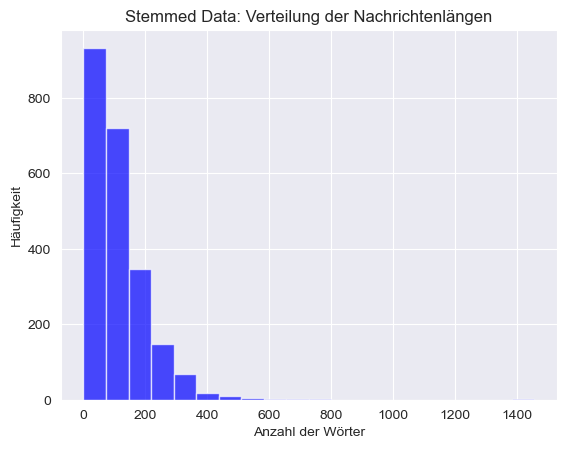

Häufigste Wörter in Stemmed Data:
would: 4968
think: 3466
event: 3195
offer: 2638
isa: 2305
also: 2241
us: 2097
intern: 2072
sponsor: 2059
russian: 1961
Analyse des Datensatzes: Lemmatized Data


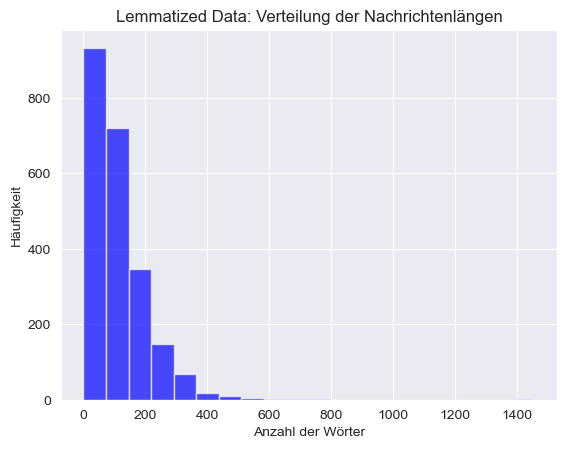

Häufigste Wörter in Lemmatized Data:
would: 4968
think: 3365
event: 3195
offer: 2350
also: 2241
isa: 2211
u: 2100
international: 1989
russian: 1961
best: 1944
Tokenisierung und Padding abgeschlossen. 2254 Sequenzen erstellt.
Tokenisierung und Padding abgeschlossen. 2254 Sequenzen erstellt.


In [10]:
# Anwendung auf beide Datensätze

# Pfade zu den Datensätzen
stemmed_data_path = "stemmed_data.csv"
lemmatized_data_path = "lemmatized_data.csv"

# Daten laden und bereinigen
stemmed_data = load_and_clean_data(stemmed_data_path)
lemmatized_data = load_and_clean_data(lemmatized_data_path)

# Analyse der Datensätze
analyze_dataset(stemmed_data, "Stemmed Data")
analyze_dataset(lemmatized_data, "Lemmatized Data")

# Tokenisierung und Padding
stemmed_sequences, stemmed_tokenizer = tokenize_and_pad(stemmed_data)
lemmatized_sequences, lemmatized_tokenizer = tokenize_and_pad(lemmatized_data)

# Labels extrahieren
stemmed_labels = stemmed_data['NegoOutcome'].map({'FinalReject': 0, 'FinalAccept': 1}).values
lemmatized_labels = lemmatized_data['NegoOutcome'].map({'FinalReject': 0, 'FinalAccept': 1}).values

# Aufteilen in Trainings- und Testdaten
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(
    stemmed_sequences, stemmed_labels, test_size=0.2, random_state=42
)

X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(
    lemmatized_sequences, lemmatized_labels, test_size=0.2, random_state=42
)

# 2. Embedding-Strategien

In [14]:
# Integration von Google Word2Vec

from gensim.models import KeyedVectors
import numpy as np

# Funktion: Google Word2Vec-Modell laden
def load_google_word2vec_model(model_path="word2vec-google-news-300.model"):
    print("Lade Google Word2Vec-Modell...")
    w2v_model = KeyedVectors.load(model_path, mmap='r')
    print("Google Word2Vec-Modell erfolgreich geladen!")
    return w2v_model

# Funktion: Embedding-Matrix erstellen
def create_embedding_matrix_google(word_index, w2v_model, embedding_dim=300):
    print("Erstelle Embedding-Matrix...")
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in w2v_model.key_to_index:
            embedding_matrix[i] = w2v_model[word]
    return embedding_matrix

# Google Word2Vec-Modell laden
google_w2v_model = load_google_word2vec_model("word2vec-google-news-300.model")

# Embedding-Matrizen für beide Tokenizer erstellen
stemmed_embedding_matrix_google = create_embedding_matrix_google(stemmed_tokenizer.word_index, google_w2v_model)
lemmatized_embedding_matrix_google = create_embedding_matrix_google(lemmatized_tokenizer.word_index, google_w2v_model)

Lade Google Word2Vec-Modell...
Google Word2Vec-Modell erfolgreich geladen!
Erstelle Embedding-Matrix...
Erstelle Embedding-Matrix...


In [15]:
# Selbst trainiertes Word2Vec

from gensim.models import Word2Vec

# Funktion: Word2Vec-Modell trainieren
def train_word2vec(sentences, vector_size=100, window=5, min_count=1, workers=4):
    print("Trainiere Word2Vec-Modell...")
    w2v_model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec-Modell erfolgreich trainiert!")
    return w2v_model

# Daten vorbereiten für Word2Vec
stemmed_sentences = stemmed_data['Content'].apply(lambda x: x.split()).tolist()
lemmatized_sentences = lemmatized_data['Content'].apply(lambda x: x.split()).tolist()

# Trainiere Word2Vec-Modelle
stemmed_w2v_model = train_word2vec(stemmed_sentences)
lemmatized_w2v_model = train_word2vec(lemmatized_sentences)

# Funktion: Embedding-Matrix erstellen
def create_embedding_matrix(word_index, w2v_model, embedding_dim):
    print("Erstelle Embedding-Matrix...")
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    return embedding_matrix

# Embedding-Matrizen erstellen
stemmed_embedding_matrix_custom = create_embedding_matrix(stemmed_tokenizer.word_index, stemmed_w2v_model, 100)
lemmatized_embedding_matrix_custom = create_embedding_matrix(lemmatized_tokenizer.word_index, lemmatized_w2v_model, 100)

Trainiere Word2Vec-Modell...
Word2Vec-Modell erfolgreich trainiert!
Trainiere Word2Vec-Modell...
Word2Vec-Modell erfolgreich trainiert!
Erstelle Embedding-Matrix...
Erstelle Embedding-Matrix...


In [16]:
# Vergleich der Embedding-Strategien

In [20]:
# Qualitatve Bewertung

# Funktion: Ähnlichkeit von Wörtern prüfen
def analyze_word_similarity(w2v_model, word, is_google=False):
    if is_google:  # Für Google Word2Vec
        if word in w2v_model:
            print(f"Ähnlichste Wörter zu '{word}':")
            similar_words = w2v_model.most_similar(word, topn=5)
            for sim_word, score in similar_words:
                print(f"  {sim_word}: {score:.4f}")
        else:
            print(f"Das Wort '{word}' ist nicht im Vokabular.")
    else:  # Für selbst trainiertes Word2Vec
        if word in w2v_model.wv:
            print(f"Ähnlichste Wörter zu '{word}':")
            similar_words = w2v_model.wv.most_similar(word, topn=5)
            for sim_word, score in similar_words:
                print(f"  {sim_word}: {score:.4f}")
        else:
            print(f"Das Wort '{word}' ist nicht im Vokabular.")

# Beispiele analysieren
print("Google Word2Vec:")
analyze_word_similarity(google_w2v_model, "accept", is_google=True)
analyze_word_similarity(google_w2v_model, "negotiation", is_google=True)

print("Selbst trainiertes Word2Vec (Stemmed):")
analyze_word_similarity(stemmed_w2v_model, "accept", is_google=False)
analyze_word_similarity(stemmed_w2v_model, "negotiation", is_google=False)

Google Word2Vec:
Ähnlichste Wörter zu 'accept':
  accepts: 0.6865
  accepted: 0.6787
  reject: 0.6692
  accepting: 0.6445
  Accepting: 0.5877
Ähnlichste Wörter zu 'negotiation':
  negotiations: 0.8169
  negotiating: 0.7532
  negations: 0.6903
  negotations: 0.6722
  Negotiations: 0.6475
Selbst trainiertes Word2Vec (Stemmed):
Ähnlichste Wörter zu 'accept':
  will: 0.9096
  conced: 0.8987
  condit: 0.8780
  concess: 0.8777
  offer: 0.8742
Das Wort 'negotiation' ist nicht im Vokabular.


In [21]:
# Quantitative Bewertung

# Funktion: Abdeckung des Tokenizer-Vokabulars prüfen
def evaluate_embedding_coverage(word_index, w2v_model, is_google=False):
    if is_google:  # Für Google Word2Vec
        covered = sum(1 for word in word_index if word in w2v_model)
    else:  # Für selbst trainiertes Word2Vec
        covered = sum(1 for word in word_index if word in w2v_model.wv)
    total = len(word_index)
    print(f"Abdeckung: {covered}/{total} ({(covered / total) * 100:.2f}%)")

# Abdeckung prüfen
print("Google Word2Vec Abdeckung (Stemmed):")
evaluate_embedding_coverage(stemmed_tokenizer.word_index, google_w2v_model, is_google=True)

print("Selbst trainiertes Word2Vec Abdeckung (Stemmed):")
evaluate_embedding_coverage(stemmed_tokenizer.word_index, stemmed_w2v_model, is_google=False)


Google Word2Vec Abdeckung (Stemmed):
Abdeckung: 3173/8347 (38.01%)
Selbst trainiertes Word2Vec Abdeckung (Stemmed):
Abdeckung: 8346/8347 (99.99%)


In [ ]:
# LSTM-Performance-Test

In [25]:
# 1. LSTM-Modellaufbau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report

# Funktion: LSTM-Modell mit Embedding trainieren und bewerten
def build_and_evaluate_lstm(X_train, y_train, X_test, y_test, embedding_matrix, input_length, title, epochs=5):
    print(f"Trainiere LSTM mit {title}")
    
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0],  # Vokabulargröße
                  output_dim=embedding_matrix.shape[1],  # Embedding-Dimension
                  weights=[embedding_matrix],  # Vortrainierte Embedding-Matrix
                  input_length=input_length,  # Länge der Eingabesequenzen
                  trainable=False),  # Embedding bleibt fixiert
        LSTM(64),  # LSTM-Schicht mit 64 Einheiten
        Dropout(0.5),  # Dropout zur Regularisierung
        Dense(1, activation='sigmoid')  # Dense-Schicht für binäre Klassifikation
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Modell trainieren
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Modell bewerten
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    report = classification_report(y_test, y_pred, target_names=["FinalReject", "FinalAccept"], output_dict=True)
    
    # Ergebnisse ausgeben
    print(f"{title} - Ergebnisse:")
    print(classification_report(y_test, y_pred, target_names=["FinalReject", "FinalAccept"]))
    return history, report

In [26]:
# 2. Training und Vergleich

# Vergleich auf Stemmed Data
print("Vergleich: Stemmed Data")
history_google_stemmed, report_google_stemmed = build_and_evaluate_lstm(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix_google, 50, "Google Word2Vec - Stemmed"
)

history_custom_stemmed, report_custom_stemmed = build_and_evaluate_lstm(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix_custom, 50, "Selbst trainiertes Word2Vec - Stemmed"
)

# Vergleich auf Lemmatized Data
print("Vergleich: Lemmatized Data")
history_google_lemmatized, report_google_lemmatized = build_and_evaluate_lstm(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix_google, 50, "Google Word2Vec - Lemmatized"
)

history_custom_lemmatized, report_custom_lemmatized = build_and_evaluate_lstm(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix_custom, 50, "Selbst trainiertes Word2Vec - Lemmatized"
)

Vergleich: Stemmed Data
Trainiere LSTM mit Google Word2Vec - Stemmed
Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7893 - loss: 0.5704 - val_accuracy: 0.7694 - val_loss: 0.5106
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8009 - loss: 0.4676 - val_accuracy: 0.7938 - val_loss: 0.4870
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8033 - loss: 0.4516 - val_accuracy: 0.7982 - val_loss: 0.4871
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8319 - loss: 0.4208 - val_accuracy: 0.7960 - val_loss: 0.4770
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8256 - loss: 0.4274 - val_accuracy: 0.8027 - val_loss: 0.4787
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Google Word2Vec - Stemmed - Ergebnisse:
              precision    recall  f1-score   support

 FinalReject       0.78      0.20      0.32       104
 FinalAccept       0.80      0.98      0.88       347

    accuracy                           0.80       451
   macro avg       0.79      0.59      0.60       451
weighted avg       0.80     

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7248 - loss: 0.5961 - val_accuracy: 0.7694 - val_loss: 0.5019
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8127 - loss: 0.4600 - val_accuracy: 0.7738 - val_loss: 0.4990
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8024 - loss: 0.4457 - val_accuracy: 0.8004 - val_loss: 0.4726
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8378 - loss: 0.3889 - val_accuracy: 0.8004 - val_loss: 0.4587
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8244 - loss: 0.4152 - val_accuracy: 0.8049 - val_loss: 0.4696
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Selbst trainiertes Word2Vec - Stemmed - Ergebnisse:
              precision    recall  f1-score   support

 FinalReject       0.79      0.21      0.33       104
 FinalAccept       0.81      0.98      0.89       347

    accuracy                           0.80       451
   macro avg       0.80      0.60      0.61       451
weighted avg     

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7940 - loss: 0.5637 - val_accuracy: 0.7694 - val_loss: 0.5027
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7960 - loss: 0.4529 - val_accuracy: 0.7694 - val_loss: 0.4911
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8413 - loss: 0.3983 - val_accuracy: 0.7916 - val_loss: 0.4857
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8536 - loss: 0.3736 - val_accuracy: 0.8004 - val_loss: 0.4781
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8470 - loss: 0.3730 - val_accuracy: 0.8137 - val_loss: 0.4349
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Google Word2Vec - Lemmatized - Ergebnisse:
              precision    recall  f1-score   support

 FinalReject       0.69      0.35      0.46       104
 FinalAccept       0.83      0.95      0.89       347

    accuracy                           0.81       451
   macro avg       0.76      0.65      0.67       451
weighted avg       0.80  

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7553 - loss: 0.5641 - val_accuracy: 0.7694 - val_loss: 0.5081
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7921 - loss: 0.4690 - val_accuracy: 0.7805 - val_loss: 0.4881
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8210 - loss: 0.4361 - val_accuracy: 0.8027 - val_loss: 0.4693
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8483 - loss: 0.3866 - val_accuracy: 0.8115 - val_loss: 0.4614
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8229 - loss: 0.4296 - val_accuracy: 0.8071 - val_loss: 0.4592
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Selbst trainiertes Word2Vec - Lemmatized - Ergebnisse:
              precision    recall  f1-score   support

 FinalReject       0.70      0.29      0.41       104
 FinalAccept       0.82      0.96      0.88       347

    accuracy                           0.81       451
   macro avg       0.76      0.63      0.65       451
weig

In [29]:
# Ergebnisse zusammenfassen

# Ergebnisse extrahieren
results = {
    "Dataset": ["Stemmed", "Stemmed", "Lemmatized", "Lemmatized"],
    "Embedding": ["Google Word2Vec", "Custom Word2Vec", "Google Word2Vec", "Custom Word2Vec"],
    "Accuracy": [
        report_google_stemmed["accuracy"],
        report_custom_stemmed["accuracy"],
        report_google_lemmatized["accuracy"],
        report_custom_lemmatized["accuracy"]
    ],
    "F1-Score (Accept)": [
        report_google_stemmed["FinalAccept"]["f1-score"],
        report_custom_stemmed["FinalAccept"]["f1-score"],
        report_google_lemmatized["FinalAccept"]["f1-score"],
        report_custom_lemmatized["FinalAccept"]["f1-score"]
    ],
    "F1-Score (Reject)": [
        report_google_stemmed["FinalReject"]["f1-score"],
        report_custom_stemmed["FinalReject"]["f1-score"],
        report_google_lemmatized["FinalReject"]["f1-score"],
        report_custom_lemmatized["FinalReject"]["f1-score"]
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

      Dataset        Embedding  Accuracy  F1-Score (Accept)  F1-Score (Reject)
0     Stemmed  Google Word2Vec  0.802661           0.884565           0.320611
1     Stemmed  Custom Word2Vec  0.804878           0.885714           0.333333
2  Lemmatized  Google Word2Vec  0.813747           0.887399           0.461538
3  Lemmatized  Custom Word2Vec  0.807095           0.884768           0.408163


/var/folders/b7/6vb5p73976zgd0ycjq0sy5l40000gn/T/ipykernel_84384/4151739371.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(


<Figure size 1400x700 with 0 Axes>

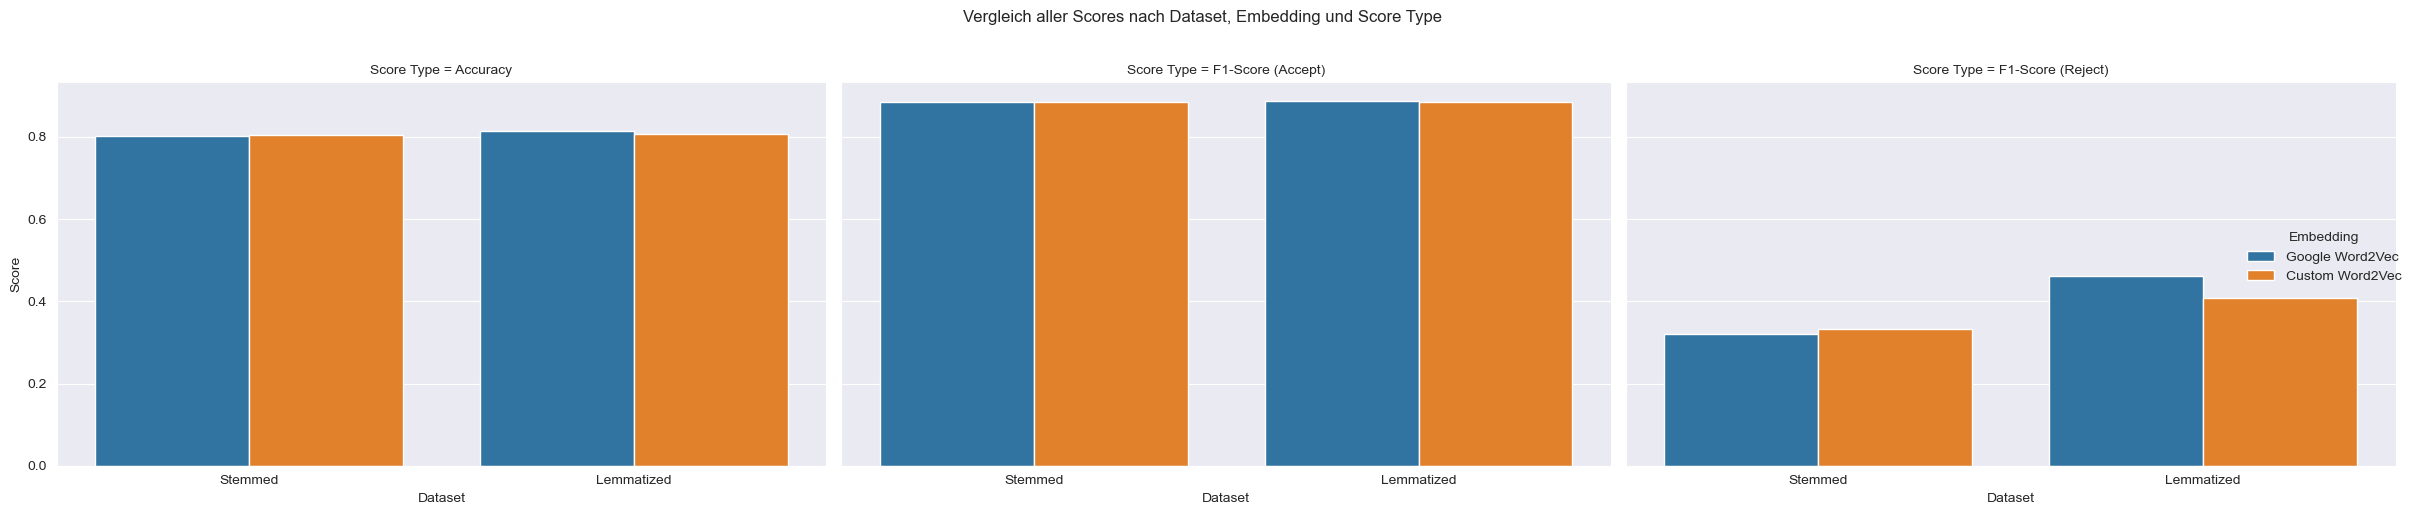

In [35]:
# Visualisierung der Accuracy

# Dataset in den Plot einbeziehen
plt.figure(figsize=(14, 7))
sns.catplot(
    kind="bar",
    data=scores_combined,
    x="Dataset",
    y="Score",
    hue="Embedding",
    col="Score Type",
    ci=None,
    height=5,
    aspect=1.5
)

# Titel und Achsenbeschriftungen
plt.suptitle("Vergleich aller Scores nach Dataset, Embedding und Score Type", y=1.02)
plt.tight_layout()
plt.show()

# 3. LSTM-Modelloptimierung

In [41]:
# Einfaches LSTM-Modell
def build_simple_lstm(embedding_matrix, input_length, lstm_units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=input_length,
                  trainable=False),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [49]:
# Baseline-Modell trainieren und vollständigen Report extrahieren

from sklearn.metrics import classification_report

# Funktion: Baseline-Modell trainieren und bewerten
def evaluate_baseline(X_train, y_train, X_test, y_test, embedding_matrix, input_length, title, epochs=10):
    print(f"Evaluierung des Baseline-Modells: {title}")
    
    # Modell definieren
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=input_length,
                  trainable=False),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Training
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Vorhersagen und Classification Report
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    report = classification_report(y_test, y_pred, target_names=["FinalReject", "FinalAccept"], output_dict=True)
    
    # Ausgabe der Ergebnisse
    print(f"{title} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["FinalReject", "FinalAccept"]))
    
    return history, report

In [50]:
# Baseline-Modell evaluieren

# Evaluation mit Classification Report für alle Kombinationen
results_baseline = []

# Google Word2Vec: Stemmed Data
history_google_stemmed, report_google_stemmed = evaluate_baseline(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix_google, 50, "Baseline - Google Word2Vec (Stemmed)"
)
results_baseline.append(("Google Word2Vec - Stemmed", report_google_stemmed))

# Google Word2Vec: Lemmatized Data
history_google_lemmatized, report_google_lemmatized = evaluate_baseline(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix_google, 50, "Baseline - Google Word2Vec (Lemmatized)"
)
results_baseline.append(("Google Word2Vec - Lemmatized", report_google_lemmatized))

# Selbst trainiertes Word2Vec: Stemmed Data
history_custom_stemmed, report_custom_stemmed = evaluate_baseline(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix_custom, 50, "Baseline - Custom Word2Vec (Stemmed)"
)
results_baseline.append(("Custom Word2Vec - Stemmed", report_custom_stemmed))

# Selbst trainiertes Word2Vec: Lemmatized Data
history_custom_lemmatized, report_custom_lemmatized = evaluate_baseline(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix_custom, 50, "Baseline - Custom Word2Vec (Lemmatized)"
)
results_baseline.append(("Custom Word2Vec - Lemmatized", report_custom_lemmatized))

Evaluierung des Baseline-Modells: Baseline - Google Word2Vec (Stemmed)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7895 - loss: 0.5541 - val_accuracy: 0.7694 - val_loss: 0.5070
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8061 - loss: 0.4575 - val_accuracy: 0.7805 - val_loss: 0.4791
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8335 - loss: 0.4256 - val_accuracy: 0.7982 - val_loss: 0.4744
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8283 - loss: 0.4123 - val_accuracy: 0.7938 - val_loss: 0.4738
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8266 - loss: 0.3916 - val_accuracy: 0.7827 - val_loss: 0.4929
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8460 - loss: 0.3381 - val_accuracy: 0.7849 - val_loss: 0.5156
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8579 - loss: 0.3533 - val_accuracy: 0.8115 - val_loss: 0.4960
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8717 - loss: 0.3159 - val_accuracy: 0.7805 - v

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7512 - loss: 0.5848 - val_accuracy: 0.7694 - val_loss: 0.5127
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8041 - loss: 0.4584 - val_accuracy: 0.7716 - val_loss: 0.4857
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8330 - loss: 0.4009 - val_accuracy: 0.7938 - val_loss: 0.4662
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8307 - loss: 0.4250 - val_accuracy: 0.8115 - val_loss: 0.4630
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8448 - loss: 0.3805 - val_accuracy: 0.8115 - val_loss: 0.4438
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8458 - loss: 0.3783 - val_accuracy: 0.8093 - val_loss: 0.4695
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8485 - loss: 0.3632 - val_accuracy: 0.7849 - val_loss: 0.4744
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8618 - loss: 0.3447 - val_accuracy: 0.8160 - val_loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7175 - loss: 0.5802 - val_accuracy: 0.7694 - val_loss: 0.5331
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7990 - loss: 0.4644 - val_accuracy: 0.7894 - val_loss: 0.4848
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8183 - loss: 0.4451 - val_accuracy: 0.8027 - val_loss: 0.4760
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8256 - loss: 0.4377 - val_accuracy: 0.8071 - val_loss: 0.4605
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8312 - loss: 0.4174 - val_accuracy: 0.8049 - val_loss: 0.4573
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8272 - loss: 0.4278 - val_accuracy: 0.8115 - val_loss: 0.4578
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8286 - loss: 0.4080 - val_accuracy: 0.8137 - val_loss: 0.4613
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8374 - loss: 0.3892 - val_accuracy: 0.8093 - val_loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7969 - loss: 0.5468 - val_accuracy: 0.7716 - val_loss: 0.5039
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7963 - loss: 0.4695 - val_accuracy: 0.7694 - val_loss: 0.5089
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7995 - loss: 0.4654 - val_accuracy: 0.7894 - val_loss: 0.4805
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8133 - loss: 0.4367 - val_accuracy: 0.8004 - val_loss: 0.4732
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8361 - loss: 0.4166 - val_accuracy: 0.8027 - val_loss: 0.4687
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8294 - loss: 0.4185 - val_accuracy: 0.8115 - val_loss: 0.4615
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8356 - loss: 0.4060 - val_accuracy: 0.8093 - val_loss: 0.4784
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8373 - loss: 0.3870 - val_accuracy: 0.8049 - val_loss: 0.

                          Model  Accuracy  Precision (Accept)  \
0     Google Word2Vec - Stemmed  0.796009            0.829457   
1  Google Word2Vec - Lemmatized  0.802661            0.820896   
2     Custom Word2Vec - Stemmed  0.809313            0.820639   
3  Custom Word2Vec - Lemmatized  0.804878            0.812048   

   Recall (Accept)  F1-Score (Accept)  Precision (Reject)  Recall (Reject)  \
0         0.925072           0.874659            0.593750         0.365385   
1         0.951009           0.881175            0.653061         0.307692   
2         0.962536           0.885942            0.704545         0.298077   
3         0.971182           0.884514            0.722222         0.250000   

   F1-Score (Reject)  
0           0.452381  
1           0.418301  
2           0.418919  
3           0.371429  


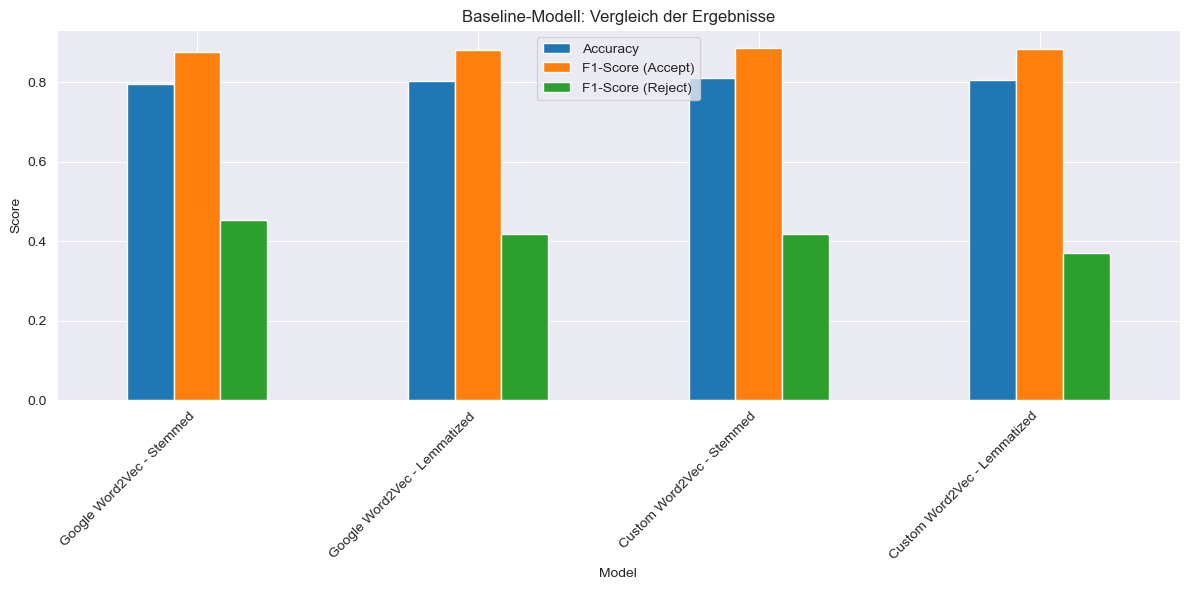

In [52]:
# Ergebnisse tabellarisch darstellen

# Ergebnisse aus dem Classification Report extrahieren
results_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision (Accept)": report["FinalAccept"]["precision"],
        "Recall (Accept)": report["FinalAccept"]["recall"],
        "F1-Score (Accept)": report["FinalAccept"]["f1-score"],
        "Precision (Reject)": report["FinalReject"]["precision"],
        "Recall (Reject)": report["FinalReject"]["recall"],
        "F1-Score (Reject)": report["FinalReject"]["f1-score"]
    }
    for name, report in results_baseline
])

print(results_df)

# Ergebnisse visualisieren
results_df.set_index("Model")[["Accuracy", "F1-Score (Accept)", "F1-Score (Reject)"]].plot(kind="bar", figsize=(12, 6))
plt.title("Baseline-Modell: Vergleich der Ergebnisse")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

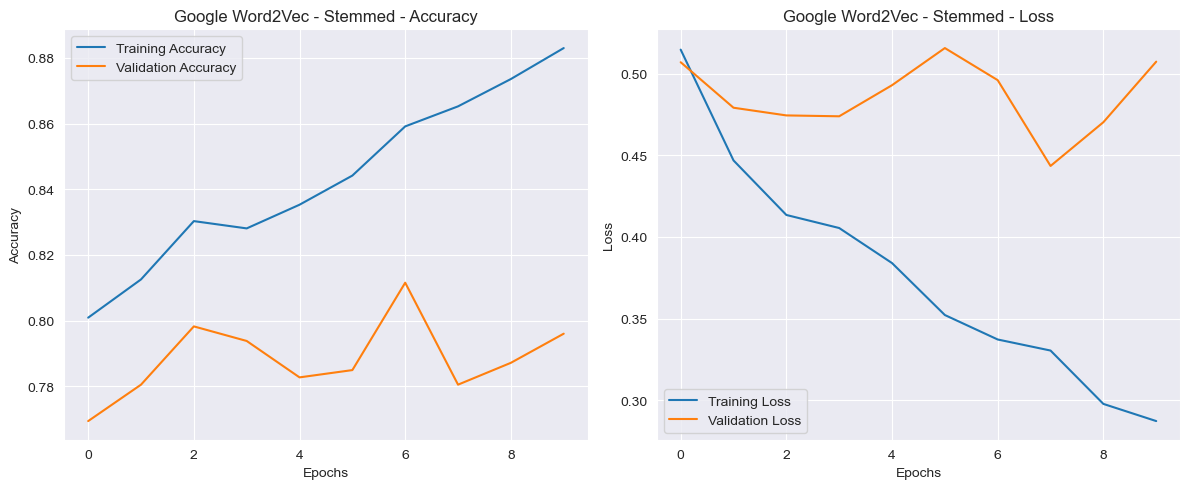

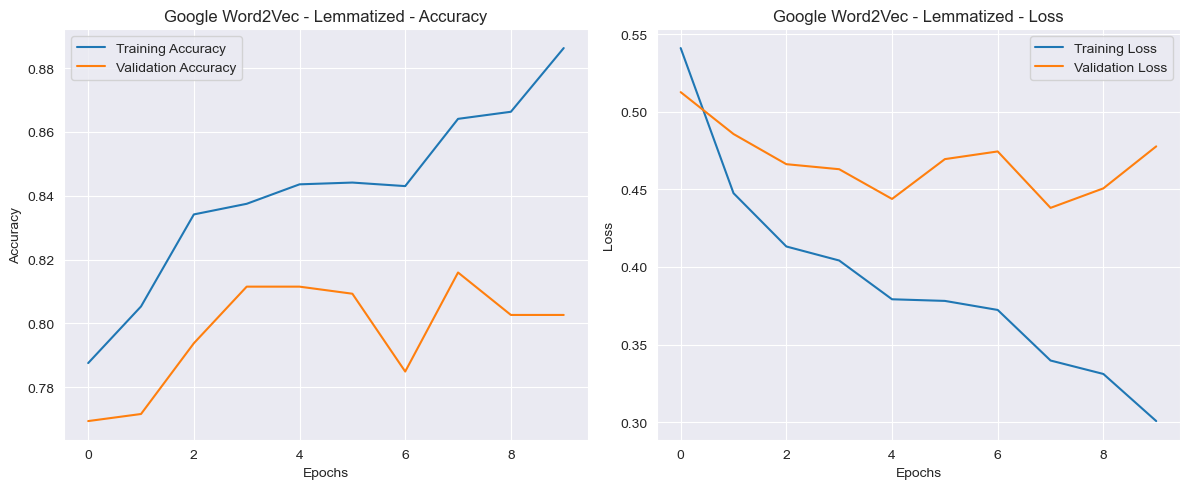

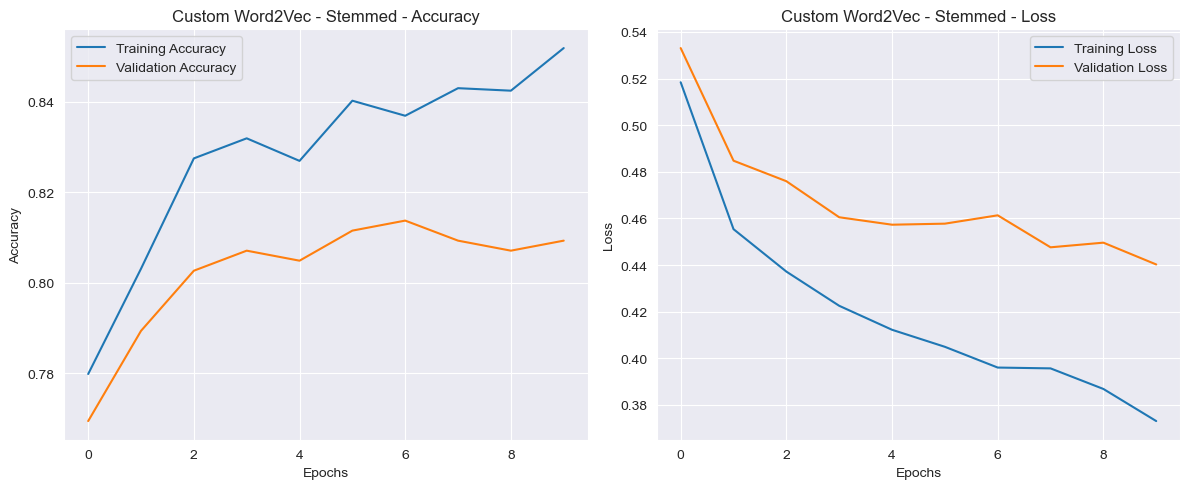

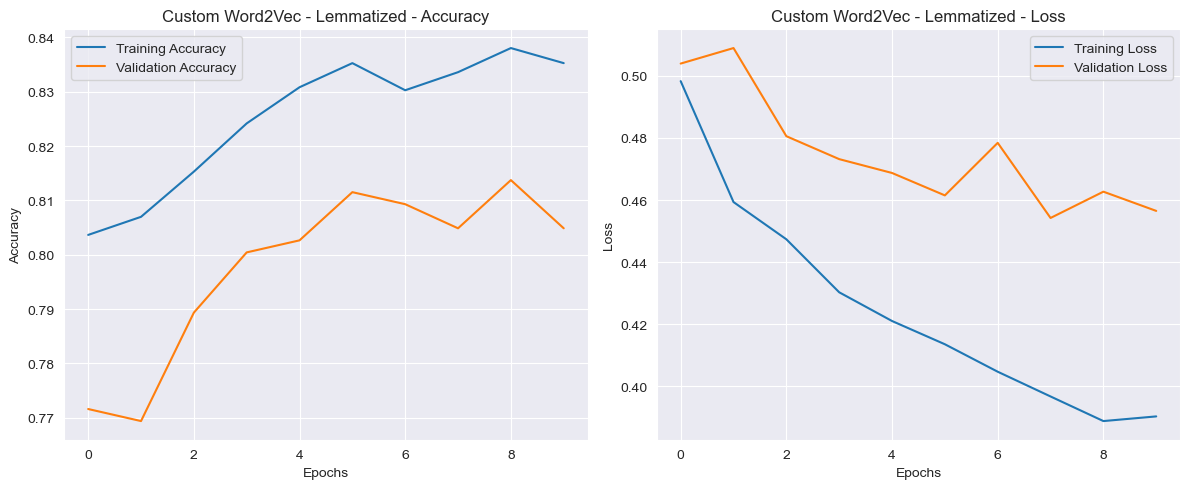

In [53]:
# Visualisierung der Learning Curves

# Funktion: Learning Curves plotten
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Learning Curves für alle Modelle plotten
plot_learning_curves(history_google_stemmed, "Google Word2Vec - Stemmed")
plot_learning_curves(history_google_lemmatized, "Google Word2Vec - Lemmatized")
plot_learning_curves(history_custom_stemmed, "Custom Word2Vec - Stemmed")
plot_learning_curves(history_custom_lemmatized, "Custom Word2Vec - Lemmatized")

In [56]:
# Einfaches LSTM-Modell
def build_simple_lstm(embedding_matrix, input_length, lstm_units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=input_length,
                  trainable=False),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [57]:
# Training und Evaluation des Baseline-Modells

from sklearn.metrics import classification_report

# Funktion: Baseline-Modell trainieren und bewerten
def evaluate_baseline(X_train, y_train, X_test, y_test, embedding_matrix, input_length, title, epochs=10):
    print(f"Evaluierung des Baseline-Modells: {title}")
    
    # Modell definieren
    model = build_simple_lstm(embedding_matrix, input_length)
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Vorhersagen und Classification Report
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    report = classification_report(y_test, y_pred, target_names=["FinalReject", "FinalAccept"], output_dict=True)
    
    # Ausgabe der Ergebnisse
    print(f"{title} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["FinalReject", "FinalAccept"]))
    
    return history, report

In [58]:
# Evaluation mit Google Word2Vec und Custom Word2Vec

# Google Word2Vec: Stemmed Data
history_google_stemmed, report_google_stemmed = evaluate_baseline(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix_google, 50, "Baseline - Google Word2Vec (Stemmed)"
)

# Google Word2Vec: Lemmatized Data
history_google_lemmatized, report_google_lemmatized = evaluate_baseline(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix_google, 50, "Baseline - Google Word2Vec (Lemmatized)"
)

# Custom Word2Vec: Stemmed Data
history_custom_stemmed, report_custom_stemmed = evaluate_baseline(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix_custom, 50, "Baseline - Custom Word2Vec (Stemmed)"
)

# Custom Word2Vec: Lemmatized Data
history_custom_lemmatized, report_custom_lemmatized = evaluate_baseline(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix_custom, 50, "Baseline - Custom Word2Vec (Lemmatized)"
)

Evaluierung des Baseline-Modells: Baseline - Google Word2Vec (Stemmed)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7557 - loss: 0.5717 - val_accuracy: 0.7694 - val_loss: 0.5131
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8167 - loss: 0.4481 - val_accuracy: 0.7694 - val_loss: 0.4973
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8230 - loss: 0.4116 - val_accuracy: 0.7738 - val_loss: 0.4856
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8192 - loss: 0.4020 - val_accuracy: 0.7827 - val_loss: 0.4926
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8252 - loss: 0.4028 - val_accuracy: 0.7849 - val_loss: 0.4952
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8516 - loss: 0.3562 - val_accuracy: 0.7916 - val_loss: 0.4540
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8689 - loss: 0.3319 - val_accuracy: 0.7805 - val_loss: 0.4563
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8557 - loss: 0.3148 - val_accuracy: 0.7938 - v

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7866 - loss: 0.5648 - val_accuracy: 0.7694 - val_loss: 0.5205
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8074 - loss: 0.4673 - val_accuracy: 0.7960 - val_loss: 0.4813
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8164 - loss: 0.4434 - val_accuracy: 0.8004 - val_loss: 0.4803
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8308 - loss: 0.4332 - val_accuracy: 0.8071 - val_loss: 0.4725
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8541 - loss: 0.3704 - val_accuracy: 0.8093 - val_loss: 0.4409
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8427 - loss: 0.3756 - val_accuracy: 0.8271 - val_loss: 0.4395
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8495 - loss: 0.3629 - val_accuracy: 0.8248 - val_loss: 0.4347
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8603 - loss: 0.3449 - val_accuracy: 0.8093 - val_loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7397 - loss: 0.5824 - val_accuracy: 0.7694 - val_loss: 0.5213
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8042 - loss: 0.4678 - val_accuracy: 0.7982 - val_loss: 0.4838
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8153 - loss: 0.4421 - val_accuracy: 0.8027 - val_loss: 0.4770
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8359 - loss: 0.4089 - val_accuracy: 0.8027 - val_loss: 0.4718
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8320 - loss: 0.4228 - val_accuracy: 0.8093 - val_loss: 0.4631
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8387 - loss: 0.3963 - val_accuracy: 0.8115 - val_loss: 0.4507
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8526 - loss: 0.3872 - val_accuracy: 0.8093 - val_loss: 0.4499
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8469 - loss: 0.3755 - val_accuracy: 0.7982 - val_loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7681 - loss: 0.5606 - val_accuracy: 0.7694 - val_loss: 0.5010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7802 - loss: 0.4856 - val_accuracy: 0.7694 - val_loss: 0.5304
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8161 - loss: 0.4426 - val_accuracy: 0.7960 - val_loss: 0.4825
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8387 - loss: 0.4265 - val_accuracy: 0.8093 - val_loss: 0.4641
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8296 - loss: 0.4145 - val_accuracy: 0.8071 - val_loss: 0.4650
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8236 - loss: 0.4128 - val_accuracy: 0.8049 - val_loss: 0.4620
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8481 - loss: 0.3800 - val_accuracy: 0.8160 - val_loss: 0.4477
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8481 - loss: 0.3898 - val_accuracy: 0.7982 - val_loss: 0.

                          Model  Accuracy  Precision (Accept)  \
0     Google Word2Vec - Stemmed  0.778271            0.842105   
1  Google Word2Vec - Lemmatized  0.811530            0.848404   
2     Custom Word2Vec - Stemmed  0.813747            0.818402   
3  Custom Word2Vec - Lemmatized  0.813747            0.816867   

   Recall (Accept)  F1-Score (Accept)  Precision (Reject)  Recall (Reject)  \
0         0.876081           0.858757            0.522222         0.451923   
1         0.919308           0.882434            0.626667         0.451923   
2         0.974063           0.889474            0.763158         0.278846   
3         0.976945           0.889764            0.777778         0.269231   

   F1-Score (Reject)  
0           0.484536  
1           0.525140  
2           0.408451  
3           0.400000  


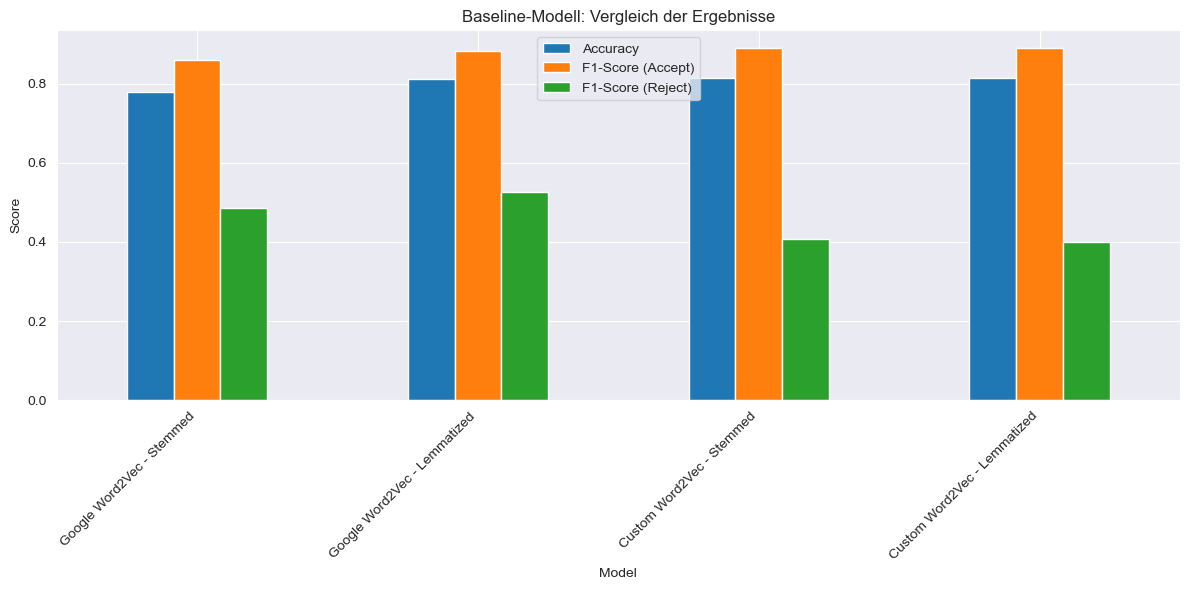

In [59]:
# Vergleich der Ergebnisse

# Ergebnisse aus dem Classification Report extrahieren
results_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision (Accept)": report["FinalAccept"]["precision"],
        "Recall (Accept)": report["FinalAccept"]["recall"],
        "F1-Score (Accept)": report["FinalAccept"]["f1-score"],
        "Precision (Reject)": report["FinalReject"]["precision"],
        "Recall (Reject)": report["FinalReject"]["recall"],
        "F1-Score (Reject)": report["FinalReject"]["f1-score"]
    }
    for name, report in [
        ("Google Word2Vec - Stemmed", report_google_stemmed),
        ("Google Word2Vec - Lemmatized", report_google_lemmatized),
        ("Custom Word2Vec - Stemmed", report_custom_stemmed),
        ("Custom Word2Vec - Lemmatized", report_custom_lemmatized)
    ]
])

print(results_df)

# Visualisierung der Ergebnisse
results_df.set_index("Model")[["Accuracy", "F1-Score (Accept)", "F1-Score (Reject)"]].plot(kind="bar", figsize=(12, 6))
plt.title("Baseline-Modell: Vergleich der Ergebnisse")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

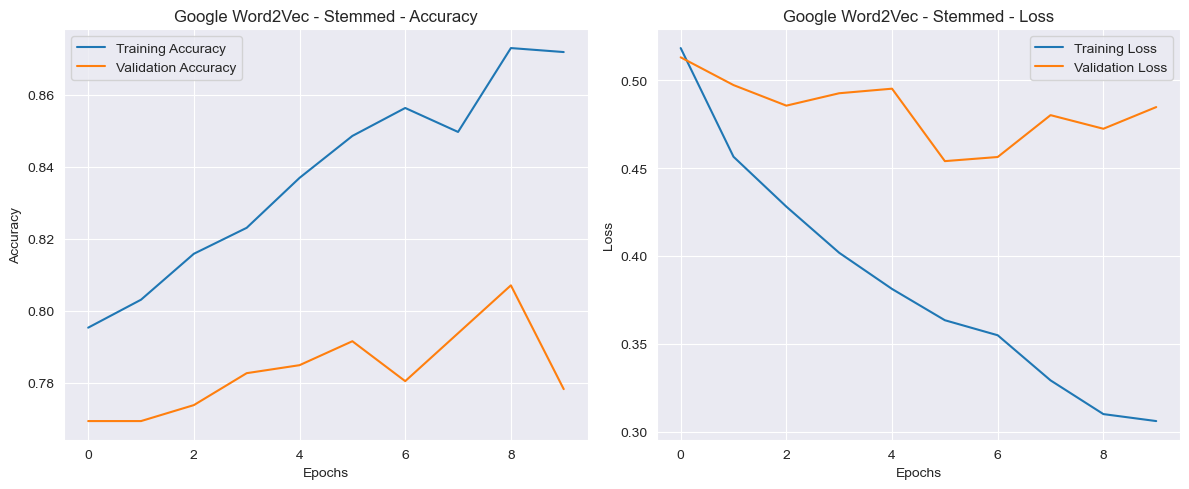

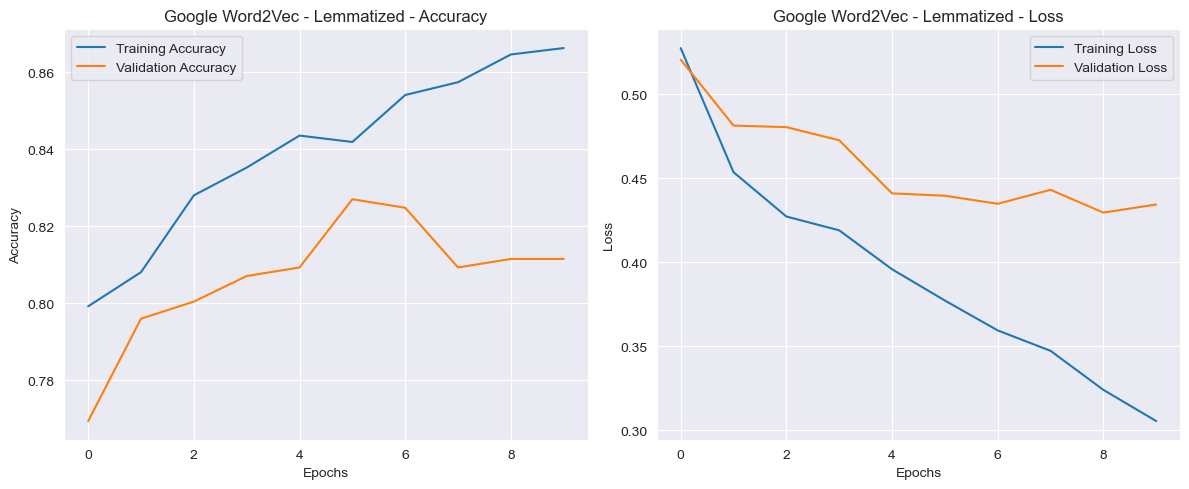

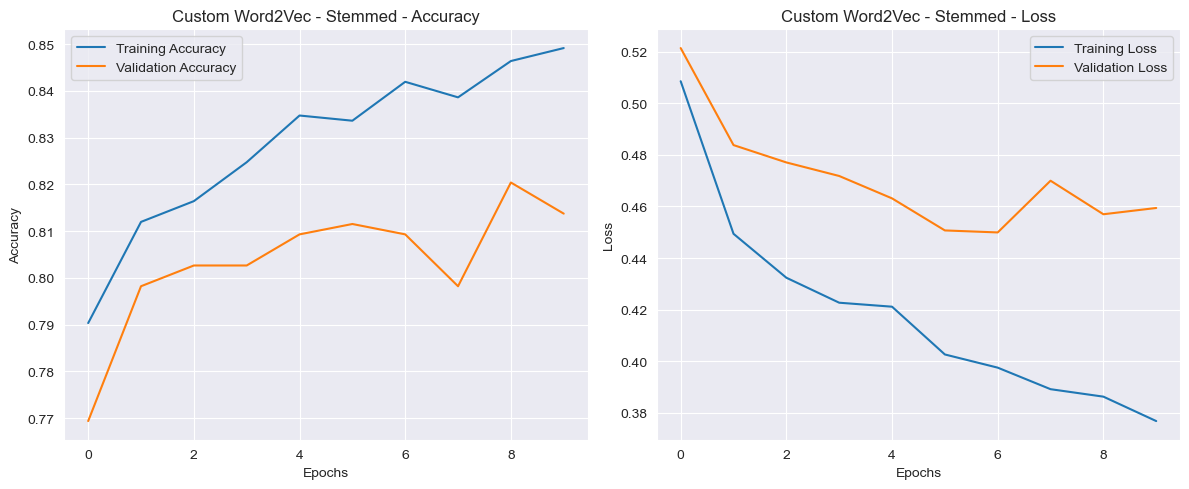

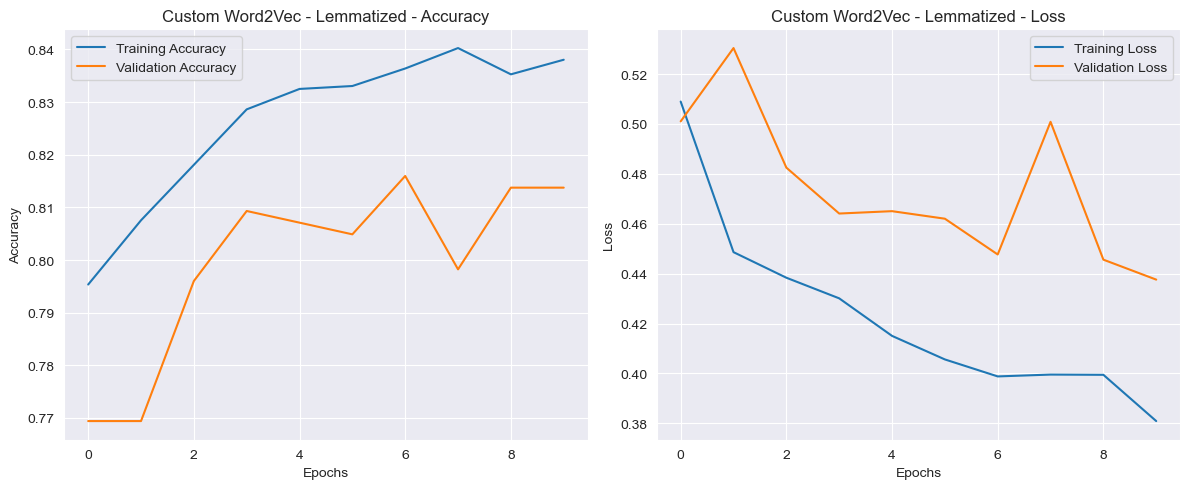

In [60]:
# Learning Curves visualisieren

# Funktion: Learning Curves plotten
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Learning Curves für alle Modelle plotten
plot_learning_curves(history_google_stemmed, "Google Word2Vec - Stemmed")
plot_learning_curves(history_google_lemmatized, "Google Word2Vec - Lemmatized")
plot_learning_curves(history_custom_stemmed, "Custom Word2Vec - Stemmed")
plot_learning_curves(history_custom_lemmatized, "Custom Word2Vec - Lemmatized")

In [ ]:
# Erweiterung mit Random Oversampling

In [67]:
# Funktion für Random Oversampling

from imblearn.over_sampling import RandomOverSampler

# Funktion: Random Oversampling anwenden
def apply_random_oversampling(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print(f"Neue Klassenverteilung: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled

In [71]:
# Funktion für Vorbereitung von Google-Daten 
def prepare_data_google(file_path, w2v_model, max_vocab_size=10000, max_sequence_length=50):
    print(f"Lade Daten aus {file_path}...")
    
    # Daten laden
    df = pd.read_csv(file_path)
    df['Content'] = df['Content'].astype(str)
    df['NegoOutcomeLabel'] = df['NegoOutcome'].map({'FinalReject': 0, 'FinalAccept': 1})
    
    # Tokenizer und Sequenzen erstellen
    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(df['Content'])
    sequences = tokenizer.texts_to_sequences(df['Content'])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    
    # Embedding-Matrix erstellen
    print("Erstelle Embedding-Matrix...")
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = w2v_model.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.key_to_index:
            embedding_matrix[i] = w2v_model[word]
    
    print(f"Embedding-Matrix erstellt mit Dimensionen: {embedding_matrix.shape}")
    
    return padded_sequences, df['NegoOutcomeLabel'].values, embedding_matrix, tokenizer

In [72]:
# Daten vorbereiten und Oversampling durchführen

# Daten für Stemmed und Lemmatized vorbereiten
X_stemmed, y_stemmed, stemmed_embedding_matrix, stemmed_tokenizer = prepare_data_google(stemmed_data_path, google_w2v_model)
X_lemmatized, y_lemmatized, lemmatized_embedding_matrix, lemmatized_tokenizer = prepare_data_google(lemmatized_data_path, google_w2v_model)

# Oversampling durchführen
X_resampled_stemmed, y_resampled_stemmed = apply_random_oversampling(X_stemmed, y_stemmed)
X_resampled_lemmatized, y_resampled_lemmatized = apply_random_oversampling(X_lemmatized, y_lemmatized)

# Aufteilen in Trainings- und Testdaten
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(
    X_resampled_stemmed, y_resampled_stemmed, test_size=0.2, random_state=42
)

X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(
    X_resampled_lemmatized, y_resampled_lemmatized, test_size=0.2, random_state=42
)

Lade Daten aus stemmed_data.csv...
Erstelle Embedding-Matrix...
Embedding-Matrix erstellt mit Dimensionen: (8354, 300)
Lade Daten aus lemmatized_data.csv...
Erstelle Embedding-Matrix...
Embedding-Matrix erstellt mit Dimensionen: (10601, 300)
Neue Klassenverteilung: [1795 1795]
Neue Klassenverteilung: [1795 1795]


In [73]:
# Baseline-Modell: Google Word2Vec mit Oversampling auf Stemmed Data
history_google_stemmed_oversampled, report_google_stemmed_oversampled = evaluate_baseline(
    X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed,
    stemmed_embedding_matrix, 50, "Baseline - Google Word2Vec (Stemmed, mit Oversampling)"
)

# Baseline-Modell: Google Word2Vec mit Oversampling auf Lemmatized Data
history_google_lemmatized_oversampled, report_google_lemmatized_oversampled = evaluate_baseline(
    X_train_lemmatized, y_train_lemmatized, X_test_lemmatized, y_test_lemmatized,
    lemmatized_embedding_matrix, 50, "Baseline - Google Word2Vec (Lemmatized, mit Oversampling)"
)

Evaluierung des Baseline-Modells: Baseline - Google Word2Vec (Stemmed, mit Oversampling)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6250 - loss: 0.6560 - val_accuracy: 0.6769 - val_loss: 0.5801
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7104 - loss: 0.5600 - val_accuracy: 0.7507 - val_loss: 0.4975
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7894 - loss: 0.4587 - val_accuracy: 0.7827 - val_loss: 0.4346
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8267 - loss: 0.3908 - val_accuracy: 0.7242 - val_loss: 0.5059
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8427 - loss: 0.3698 - val_accuracy: 0.8231 - val_loss: 0.3869
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8696 - loss: 0.3230 - val_accuracy: 0.8635 - val_loss: 0.3485
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9127 - loss: 0.2473 - val_accuracy: 0.8677 - val_loss: 0.3368
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9303 - loss: 0.2050 - val_accuracy: 0.8760 - v

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5838 - loss: 0.6577 - val_accuracy: 0.7145 - val_loss: 0.5447
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7150 - loss: 0.5301 - val_accuracy: 0.7479 - val_loss: 0.5065
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7786 - loss: 0.4620 - val_accuracy: 0.8022 - val_loss: 0.4342
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8355 - loss: 0.3964 - val_accuracy: 0.8120 - val_loss: 0.4049
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8511 - loss: 0.3608 - val_accuracy: 0.7841 - val_loss: 0.4367
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8782 - loss: 0.3040 - val_accuracy: 0.8426 - val_loss: 0.3446
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9009 - loss: 0.2660 - val_accuracy: 0.8733 - val_loss: 0.3269
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9261 - loss: 0.2110 - val_accuracy: 0.8217 - val_loss: 0.

                                              Model  Accuracy  \
0     Google Word2Vec - Stemmed (ohne Oversampling)  0.778271   
1      Google Word2Vec - Stemmed (mit Oversampling)  0.881616   
2  Google Word2Vec - Lemmatized (ohne Oversampling)  0.811530   
3   Google Word2Vec - Lemmatized (mit Oversampling)  0.910864   

   Precision (Accept)  Recall (Accept)  F1-Score (Accept)  Precision (Reject)  \
0            0.842105         0.876081           0.858757            0.522222   
1            0.945513         0.812672           0.874074            0.832512   
2            0.848404         0.919308           0.882434            0.626667   
3            0.921127         0.900826           0.910864            0.900826   

   Recall (Reject)  F1-Score (Reject)  
0         0.451923           0.484536  
1         0.952113           0.888305  
2         0.451923           0.525140  
3         0.921127           0.910864  


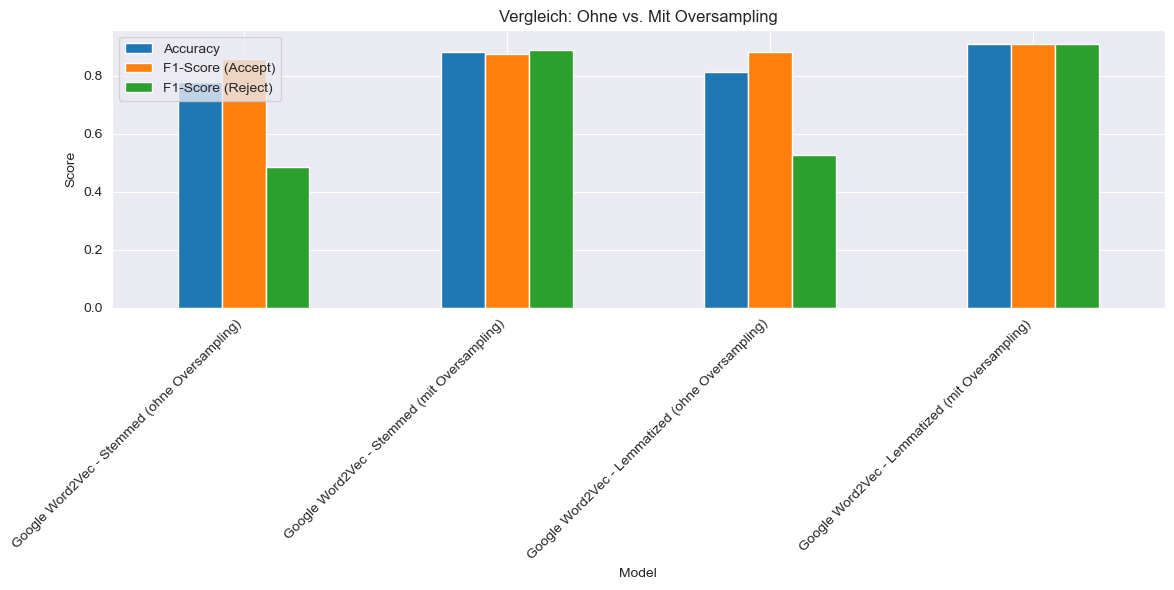

In [74]:
# Ergebnisse vergleichen

# Ergebnisse kombinieren
results_with_oversampling = [
    ("Google Word2Vec - Stemmed (ohne Oversampling)", report_google_stemmed),
    ("Google Word2Vec - Stemmed (mit Oversampling)", report_google_stemmed_oversampled),
    ("Google Word2Vec - Lemmatized (ohne Oversampling)", report_google_lemmatized),
    ("Google Word2Vec - Lemmatized (mit Oversampling)", report_google_lemmatized_oversampled)
]

# Tabelle erstellen
results_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision (Accept)": report["FinalAccept"]["precision"],
        "Recall (Accept)": report["FinalAccept"]["recall"],
        "F1-Score (Accept)": report["FinalAccept"]["f1-score"],
        "Precision (Reject)": report["FinalReject"]["precision"],
        "Recall (Reject)": report["FinalReject"]["recall"],
        "F1-Score (Reject)": report["FinalReject"]["f1-score"]
    }
    for name, report in results_with_oversampling
])

print(results_df)

# Ergebnisse visualisieren
results_df.set_index("Model")[["Accuracy", "F1-Score (Accept)", "F1-Score (Reject)"]].plot(kind="bar", figsize=(12, 6))
plt.title("Vergleich: Ohne vs. Mit Oversampling")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

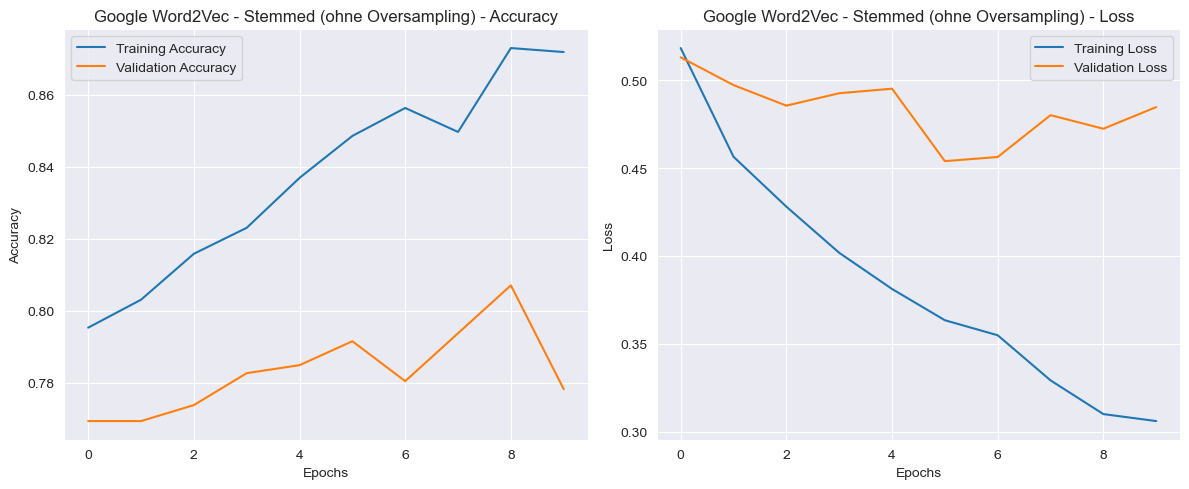

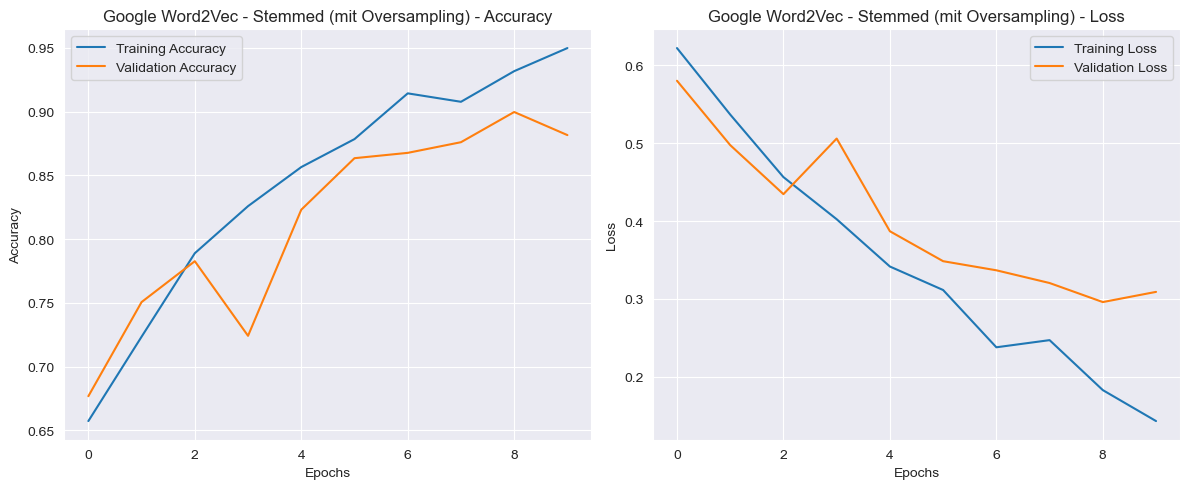

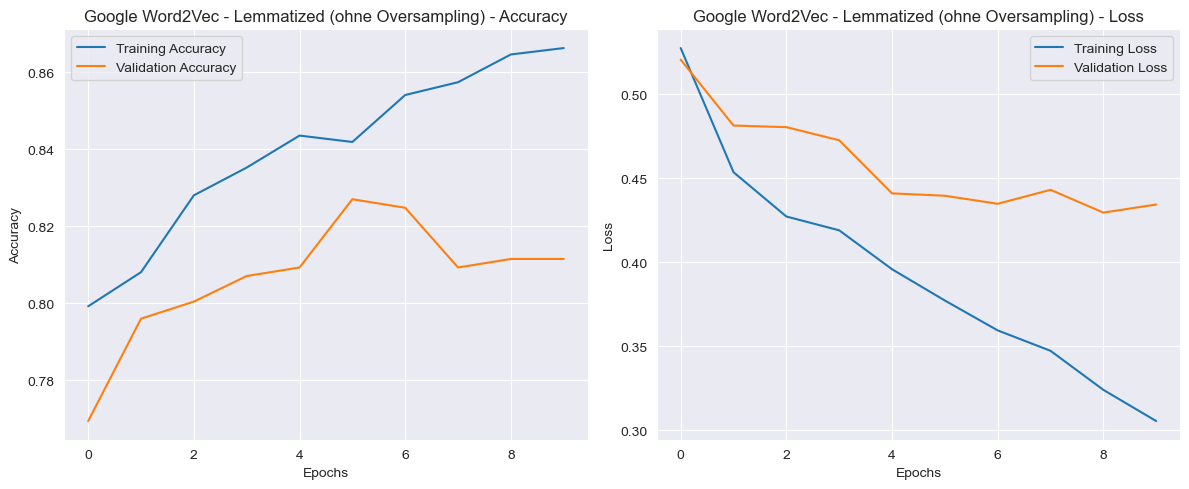

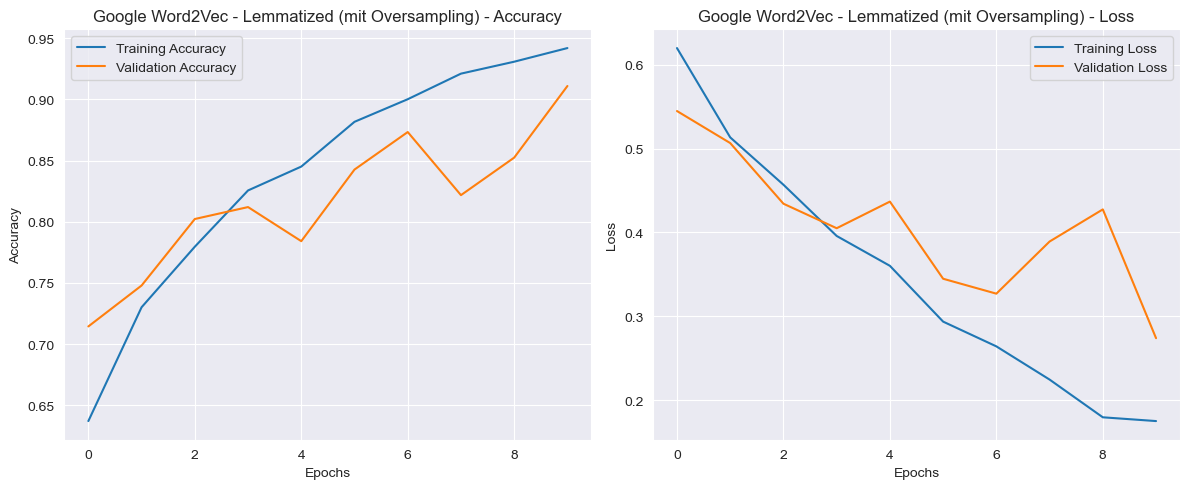

In [76]:
# Learning Curves vergleichen

# Stemmed Data
# Ohne Oversampling
plot_learning_curves(history_google_stemmed, "Google Word2Vec - Stemmed (ohne Oversampling)")
# Mit Oversampling
plot_learning_curves(history_google_stemmed_oversampled, "Google Word2Vec - Stemmed (mit Oversampling)")

# Lemmatized Data
# Ohne Oversampling
plot_learning_curves(history_google_lemmatized, "Google Word2Vec - Lemmatized (ohne Oversampling)")
# Mit Oversampling
plot_learning_curves(history_google_lemmatized_oversampled, "Google Word2Vec - Lemmatized (mit Oversampling)")

In [ ]:
# Interpretation der Ergebnisse

                                              Model  Accuracy  \
0     Google Word2Vec - Stemmed (ohne Oversampling)  0.778271   
1      Google Word2Vec - Stemmed (mit Oversampling)  0.881616   
2  Google Word2Vec - Lemmatized (ohne Oversampling)  0.811530   
3   Google Word2Vec - Lemmatized (mit Oversampling)  0.910864   

   Precision (Accept)  Recall (Accept)  F1-Score (Accept)  Precision (Reject)  \
0            0.842105         0.876081           0.858757            0.522222   
1            0.945513         0.812672           0.874074            0.832512   
2            0.848404         0.919308           0.882434            0.626667   
3            0.921127         0.900826           0.910864            0.900826   

   Recall (Reject)  F1-Score (Reject)  
0         0.451923           0.484536  
1         0.952113           0.888305  
2         0.451923           0.525140  
3         0.921127           0.910864  


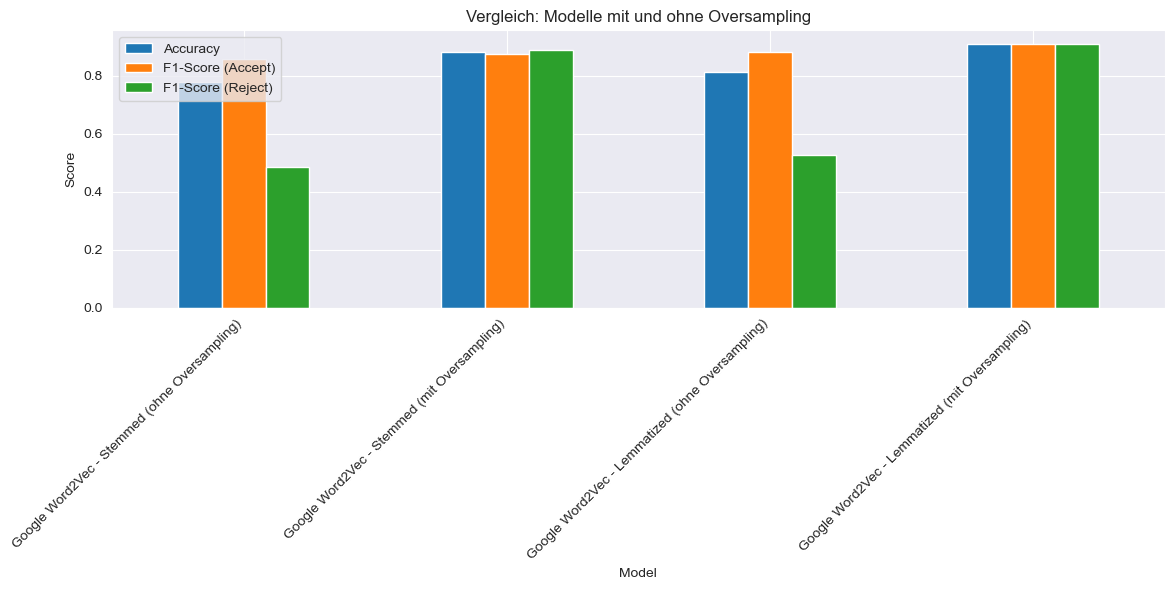

In [77]:
# Ergebnisse kombinieren
results_with_oversampling = [
    ("Google Word2Vec - Stemmed (ohne Oversampling)", report_google_stemmed),
    ("Google Word2Vec - Stemmed (mit Oversampling)", report_google_stemmed_oversampled),
    ("Google Word2Vec - Lemmatized (ohne Oversampling)", report_google_lemmatized),
    ("Google Word2Vec - Lemmatized (mit Oversampling)", report_google_lemmatized_oversampled)
]

# Tabelle erstellen
results_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision (Accept)": report["FinalAccept"]["precision"],
        "Recall (Accept)": report["FinalAccept"]["recall"],
        "F1-Score (Accept)": report["FinalAccept"]["f1-score"],
        "Precision (Reject)": report["FinalReject"]["precision"],
        "Recall (Reject)": report["FinalReject"]["recall"],
        "F1-Score (Reject)": report["FinalReject"]["f1-score"]
    }
    for name, report in results_with_oversampling
])

print(results_df)

# Visualisierung der Ergebnisse
results_df.set_index("Model")[["Accuracy", "F1-Score (Accept)", "F1-Score (Reject)"]].plot(kind="bar", figsize=(12, 6))
plt.title("Vergleich: Modelle mit und ohne Oversampling")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [78]:
# Learning Curves vergleichen

# Funktion: Overfitting bewerten
def evaluate_overfitting(history, title):
    training_acc = history.history['accuracy'][-1]
    validation_acc = history.history['val_accuracy'][-1]
    print(f"{title}: Training Accuracy = {training_acc:.4f}, Validation Accuracy = {validation_acc:.4f}")
    print(f"Unterschied (Overfitting): {abs(training_acc - validation_acc):.4f}")

# Overfitting für alle Modelle bewerten
print("Overfitting-Bewertung:")
evaluate_overfitting(history_google_stemmed, "Google Word2Vec - Stemmed (ohne Oversampling)")
evaluate_overfitting(history_google_stemmed_oversampled, "Google Word2Vec - Stemmed (mit Oversampling)")
evaluate_overfitting(history_google_lemmatized, "Google Word2Vec - Lemmatized (ohne Oversampling)")
evaluate_overfitting(history_google_lemmatized_oversampled, "Google Word2Vec - Lemmatized (mit Oversampling)")

Overfitting-Bewertung:
Google Word2Vec - Stemmed (ohne Oversampling): Training Accuracy = 0.8719, Validation Accuracy = 0.7783
Unterschied (Overfitting): 0.0936
Google Word2Vec - Stemmed (mit Oversampling): Training Accuracy = 0.9499, Validation Accuracy = 0.8816
Unterschied (Overfitting): 0.0682
Google Word2Vec - Lemmatized (ohne Oversampling): Training Accuracy = 0.8663, Validation Accuracy = 0.8115
Unterschied (Overfitting): 0.0548
Google Word2Vec - Lemmatized (mit Oversampling): Training Accuracy = 0.9419, Validation Accuracy = 0.9109
Unterschied (Overfitting): 0.0310
